# How to convert DNN into BNN

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This notebook aims to showcase how can you convert a statistical deep neural network that predict a point into a bayesian neural network that predict the distribution instead. 
    </p>
</div>

Let us start by importing libraries.

In [1]:
import jax
import jax.numpy as jnp
import inspeqtor.experimental as sq
from functools import partial

## Get synthetic dataset ready 🚀

Here we are working with synthetic dataset. So, we need to define a simulator, perform an experiment, prepare the dataset for model training/inference, benchmarking. Luckily, `inspeqtor` provide a serveral helper functions and predefined noise model for user to quickly get stuff setting up.

In [ ]:
def get_data():
    # This is the predefined noise model that we are going to work with.
    data_model = sq.predefined.get_predefined_data_model_m1()

    # Now, we use the noise model to performing the data using simulator.
    exp_data, _, _, _ = sq.predefined.generate_experimental_data(
        key=jax.random.key(0),
        hamiltonian=data_model.total_hamiltonian,
        sample_size=100,
        strategy=sq.predefined.SimulationStrategy.SHOT,
        get_qubit_information_fn=lambda: data_model.qubit_information,
        get_control_sequence_fn=lambda: data_model.control_sequence,
        method=sq.predefined.WhiteboxStrategy.TROTTER,
        trotter_steps=10_000,
    )

    # Now we can prepare the dataset that ready to use.
    whitebox = sq.physics.make_trotterization_solver(
        data_model.ideal_hamiltonian,
        data_model.control_sequence,
        data_model.dt,
        trotter_steps=10_000,
    )
    loaded_data = sq.predefined.prepare_data(
        exp_data, data_model.control_sequence, whitebox
    )

    # Here, we just bundling things up for convinience uses.
    key = jax.random.key(0)
    key, random_split_key = jax.random.split(key)
    (
        train_pulse_parameters,
        train_unitaries,
        train_expectation_values,
        test_pulse_parameters,
        test_unitaries,
        test_expectation_values,
    ) = sq.utils.random_split(
        random_split_key,
        int(loaded_data.control_parameters.shape[0] * 0.1),  # Test size
        loaded_data.control_parameters,
        loaded_data.unitaries,
        loaded_data.expectation_values,
    )

    shots = loaded_data.experiment_data.experiment_config.shots

    train_binaries = sq.utils.eigenvalue_to_binary(
        sq.utils.expectation_value_to_eigenvalue(train_expectation_values, shots)
    )
    train_binaries = jnp.swapaxes(jnp.swapaxes(train_binaries, 1, 2), 0, 1)

    test_binaries = sq.utils.eigenvalue_to_binary(
        sq.utils.expectation_value_to_eigenvalue(test_expectation_values, shots)
    )

    test_binaries = jnp.swapaxes(jnp.swapaxes(test_binaries, 1, 2), 0, 1)

    assert train_binaries.shape == (shots, train_pulse_parameters.shape[0], 18)
    assert test_binaries.shape == (shots, test_pulse_parameters.shape[0], 18)

    train_data = sq.optimize.DataBundled(
        control_params=sq.predefined.drag_feature_map(train_pulse_parameters),
        unitaries=train_unitaries,
        observables=train_binaries,
        aux=train_expectation_values,
    )

    test_data = sq.optimize.DataBundled(
        control_params=sq.predefined.drag_feature_map(test_pulse_parameters),
        unitaries=test_unitaries,
        observables=test_binaries,
        aux=test_expectation_values,
    )
    # Return data ready to use.
    return data_model, loaded_data, train_data, test_data

data_model, loaded_data, train_data, test_data = get_data()

## Routes to convert DNN model to BNN model

`inspeqtor` provides serveral ways to convert DNN to BNN and user can also create the BNN from scratch too! For the predefined models or model defined using `flax`, `numpyro.contrib.module` implemented the function that transform the statistical model to probabilistic model with ease. Thus, `inspeqtor` provides a wrapper function `make_flax_probabilistic_graybox_model` that help convet user defined model into a proper probabilistic Graybox model. Here are examples of how to do it.

For the `linen` models, user has to use `random_flax_module` for a `flax_module` argument to `make_flax_probabilistic_graybox_model` function. Similar to `models` version, the adapter function that transform model's output into expectation values has to be use appropiately.

In [ ]:
from numpyro.contrib.module import random_flax_module

base_model, adapter_fn, flax_module = (
    sq.models.linen.UnitaryModel([10, 10]),
    sq.probabilistic.toggling_unitary_predictive_fn,
    random_flax_module,
)

In [ ]:
base_model, adapter_fn, flax_module = (
    sq.models.linen.WoModel([5], [5]),
    sq.probabilistic.wo_model_prediction_to_expvals,
    random_flax_module,
)

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        For <code>nnx</code> models, use <code>sq.probabilistic.random_nnx_module</code> instead of <code>random_nnx_module</code> exported from <code>numpyro.contrib.module</code>. Because, we modified some behavior of the function for it to work properly with out predefined models. In the future, this might be change.
    </p>
</div>



In [ ]:
from flax import nnx

base_model, adapter_fn, flax_module = (
    sq.models.nnx.UnitaryModel([8, 8], rngs=nnx.Rngs(0)),
    sq.probabilistic.toggling_unitary_predictive_fn,
    sq.probabilistic.random_nnx_module,
)

Finally, we can define `graybox` model with the choice of the DNN model. For the custom `linen` and `nnx` models, you have to define a corresponding `adapter_fn` as well.

In [ ]:
graybox_model = sq.probabilistic.make_flax_probabilistic_graybox_model(
    name="graybox",
    base_model=base_model,
    model_prediction_to_expvals_fn=adapter_fn,
    prior=sq.probabilistic.dist.Normal(0, 1),
    flax_module=flax_module,
)

In the case that you need a completely in control of the model behavior. You can define the probabilistic mdoel from scratch too. You can do this using our primitive bayesian neural network components that design to be compatible with `numpyro`.

Below is $\hat{W}_{O}$-based model defined from scratch to mirror the `flax` implementation. Note that we use `sq.probabilistic.dense_layer` for our mathematical operation. The mental model of defining probabilistic model using our primitive as example below is that you can define it as operating on point prediction, while `numpyro` will handle the distribution part for you.

In [ ]:
import typing
from numpyro import distributions as dist


def make_basic_blackbox_bnn_model(
    name: str,
    priors_fn: typing.Callable[
        [str], dist.Distribution
    ] = sq.probabilistic.default_priors_fn,
    hidden_sizes_1: tuple[int, ...] = (),
    hidden_sizes_2: tuple[int, ...] = (),
    pauli_operators: tuple[str, ...] = ("X", "Y", "Z"),
    NUM_UNITARY_PARAMS: int = 3,
    NUM_DIAGONAL_PARAMS: int = 2,
    unitary_activation_fn: typing.Callable[[jnp.ndarray], jnp.ndarray] = lambda x: 2
    * jnp.pi
    * jax.nn.hard_sigmoid(x),
    diagonal_activation_fn: typing.Callable[[jnp.ndarray], jnp.ndarray] = lambda x: (
        2 * jax.nn.hard_sigmoid(x)
    )
    - 1,
) -> typing.Callable:
    """Function to create Blackbox BNN with custom activation functions for unitary and diagonal output

    Args:
        unitary_activation_fn: Activation function for unitary parameters.
        diagonal_activation_fn: Activation function for diagonal parameters.
        priors_fn: Function to generate priors for parameters.

    Returns:
        Callable: Blackbox BNN model function
    """

    def blackbox_bnn_model(
        x: jnp.ndarray,
    ) -> dict[str, jnp.ndarray]:
        # Main trunk network
        shared_x = x
        for i, hidden_size in enumerate(hidden_sizes_1):
            shared_x = sq.probabilistic.dense_layer(
                shared_x,
                f"{name}/shared/Dense_{i}",
                shared_x.shape[-1],
                hidden_size,
                priors_fn,
            )
            shared_x = jax.nn.relu(shared_x)

        Wos: dict[str, jnp.ndarray] = dict()

        for op in pauli_operators:
            # Branch network for each Pauli operator
            branch_x = jnp.copy(shared_x)

            # Sub hidden layers for this operator
            for i, hidden_size in enumerate(hidden_sizes_2):
                branch_x = sq.probabilistic.dense_layer(
                    branch_x,
                    f"{name}/Pauli_{op}/Dense_{i}",
                    branch_x.shape[-1],
                    hidden_size,
                    priors_fn,
                )
                branch_x = jax.nn.relu(branch_x)

            # Unitary parameters output
            unitary_params = sq.probabilistic.dense_layer(
                branch_x,
                f"{name}/U_{op}",
                branch_x.shape[-1],
                NUM_UNITARY_PARAMS,
                priors_fn,
            )
            unitary_params = unitary_activation_fn(unitary_params)

            # Diagonal parameters output
            diag_params = sq.probabilistic.dense_layer(
                branch_x,
                f"{name}/D_{op}",
                branch_x.shape[-1],
                NUM_DIAGONAL_PARAMS,
                priors_fn,
            )
            diag_params = diagonal_activation_fn(diag_params)

            # Combine into Wo using your existing function
            Wos[op] = sq.model.Wo_2_level_v3(unitary_params, diag_params)

        numpyro.deterministic(f"{name}/Wo", Wos)  # type: ignore
        return Wos

    return blackbox_bnn_model


def probabilistic_graybox_model(
    control_parameters: jnp.ndarray,
    unitaries: jnp.ndarray,
    priors_fn=sq.probabilistic.default_priors_fn,
):
    # Inner broadcast.
    samples_shape = control_parameters.shape[:-2]
    unitaries = jnp.broadcast_to(unitaries, samples_shape + unitaries.shape[-3:])

    model = make_basic_blackbox_bnn_model("graybox", priors_fn=priors_fn)

    output = model(control_parameters)

    expectation_values = sq.probabilistic.wo_model_prediction_to_expvals(
        output, unitaries
    )

    return expectation_values


# Super simple prior function that will initial every parameter 
# to Normal distribution with zero mean and standand deviation of one.
def prior_fn(param_name: str):
    return dist.Normal(0, 1)


graybox_model = partial(probabilistic_graybox_model, priors_fn=prior_fn)

You can inspect the model using `sq.probabilistic.get_trace`. Below, we visualize the trace of model using `nnx.display`. Note that `get_trace` handle the random key for you under the hood. User can suppliment their own key if desire.

In [14]:
from flax import nnx

nnx.display(sq.probabilistic.get_trace(graybox_model)(test_data.control_params, test_data.unitaries))

## Stochastic Variational Inference of BNN

Let import the goodies to use. 

In [5]:
import numpyro
from numpyro.infer import (
    SVI,
    TraceMeanField_ELBO,
)
from alive_progress import alive_it

You will see below that probabilistic model (`model` variable) accept `graybox` which can be defined from multiple ways demonstrated previously. In the following code snippet, we also use custom guide and custom training loop to demonstrate the flexibility.

In [10]:
model = sq.probabilistic.make_probabilistic_model(
    graybox_probabilistic_model=graybox_model,
)

guide = sq.probabilistic.auto_diagonal_normal_guide(
    model,
    train_data.control_params,
    train_data.unitaries,
    train_data.observables,
    key=jax.random.key(0),
)

NUM_STEPS = 10_000
optimizer = sq.optimize.get_default_optimizer(NUM_STEPS)

svi = SVI(
    model=model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(optimizer),
    loss=TraceMeanField_ELBO(),
)

svi_state = svi.init(
    rng_key=jax.random.key(0),
    control_parameters=train_data.control_params,
    unitaries=train_data.unitaries,
    observables=train_data.observables,
)

update_fn = sq.probabilistic.make_update_fn(
    svi,
    control_parameters=train_data.control_params,
    unitaries=train_data.unitaries,
    observables=train_data.observables,
)

eval_fn = sq.probabilistic.make_evaluate_fn(
    svi,
    control_parameters=test_data.control_params,
    unitaries=test_data.unitaries,
    observables=test_data.observables,
)

eval_losses = []
losses = []
for i in alive_it(range(NUM_STEPS), force_tty=True):
    svi_state, loss = jax.jit(update_fn)(svi_state)
    eval_loss = jax.jit(eval_fn)(svi_state)
    losses.append(loss)
    eval_losses.append(eval_loss)

svi_result = sq.probabilistic.SVIRunResult(
    svi.get_params(svi_state), svi_state, jnp.stack(losses), jnp.stack(eval_losses)
)

|████████████████████████████████████████| 10000/10000 [100%] in 46.0s (217.63/s


## Visualize the Negative ELBO loss

Belows, we rescale the loss with the number of the sample and plot it with `matplotlib`.

In [7]:
import matplotlib.pyplot as plt

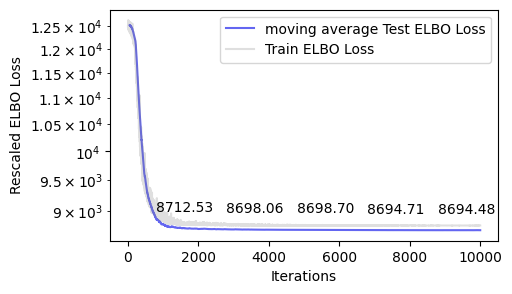

In [11]:
rescaled_eval_losses = svi_result.eval_losses / test_data.control_params.shape[0]
rescaled_train_losses = svi_result.losses / train_data.control_params.shape[0]

iterations = jnp.arange(len(rescaled_train_losses))
fig, ax = plt.subplots(figsize=(5, 3))
ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    rescaled_eval_losses,
    ax=ax,
    color="#6366f1",
    label="moving average Test ELBO Loss",
)
ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    rescaled_train_losses,
    ax,
    window=1,
    annotate_at=[],
    color="gray",
    alpha=0.25,
    label="Train ELBO Loss",
)
ax.set_yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Rescaled ELBO Loss")
ax.legend()
